In [1]:
# Simple CNN model for CIFAR-10
# Author: Gabriel Tambara Rabelo

import numpy
import torch
import random
import tensorflow as tf
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils

seed = 180017021
numpy.random.seed(seed)

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_validation = []
y_validation = []

for i in range(int(len(y_test) / 2)):
  x_validation.append(x_test[i])
  y_validation.append(y_test[i])

x_validation = numpy.array(x_validation)
y_validation = numpy.array(y_validation)

for i in range(int(len(y_test) / 2)):
  x_test = numpy.delete(x_test, i, axis=0)
  y_test = numpy.delete(y_test, i, axis=0)

x_train = x_train / 255.0
x_validation = x_validation / 255.0
x_test = x_test / 255.0


170498071/170498071 [==============================] - 6s 0us/step


In [3]:
import math

def plot_feature_maps(model, figsize=(10, 10)):

    index = numpy.random.randint(0, len(x_test))
    input_image = numpy.array([x_test[index]])
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    activations = activation_model.predict(input_image)

    for layer_activation, layer_name in zip(activations, layer_names):
        num_channels = layer_activation.shape[-1]
        rows = int(math.sqrt(num_channels)) + 1
        cols = math.ceil(num_channels / rows)

        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle(layer_name)

        for i, ax in enumerate(axes.flat):
            if i < num_channels:
                ax.imshow(layer_activation[0, :, :, i], cmap='GnBu')
            ax.axis('off')

        plt.tight_layout()
        plt.show()


In [4]:
def plot_confusion_matrix(model, y_pred, y_test, labels):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='GnBu', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

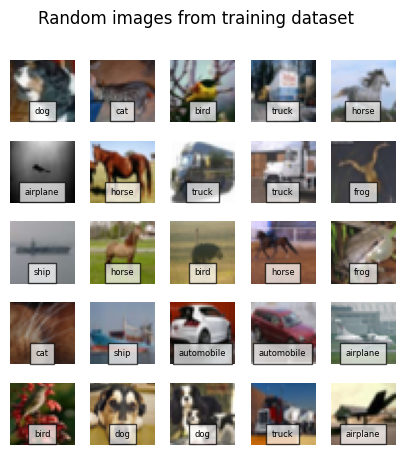

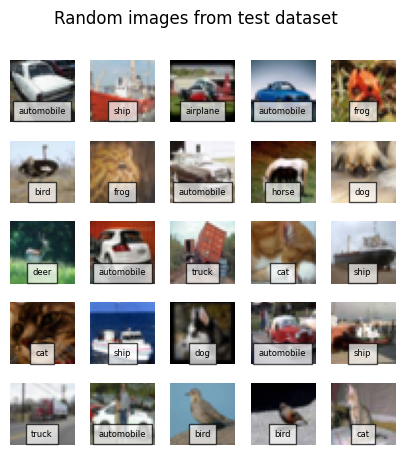

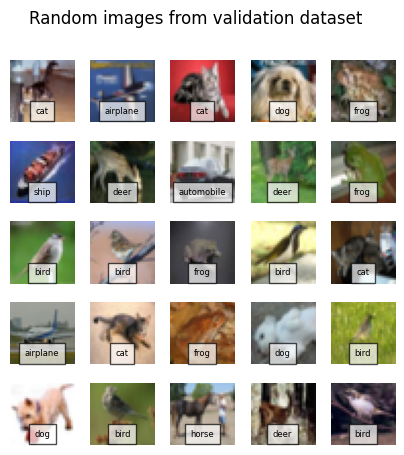

In [5]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_examples(x_, y_, groupname):
  fig_img, axes_img = plt.subplots(5, 5, figsize = (5,5))
  axes_img = axes_img.ravel()

  for i in range(25):
      index = numpy.random.randint(0, len(x_))
      axes_img[i].imshow(x_[index,1:])
      label_index = int(y_[index])

      axes_img[i].axis('off')
      axes_img[i].set_title(labels[label_index], fontsize = 6, y=-0.001, bbox=dict(facecolor='white', alpha=0.7))

  plt.subplots_adjust(hspace=0.3)
  fig_img.suptitle('Random images from ' + groupname + ' dataset')

# for the training dataset:
# data agumentation elements are added during the training, to make use of gpu optimization
plot_examples(x_train, y_train, 'training')

# for the test dataset:
plot_examples(x_test, y_test, 'test')

# for the validation dataset:
plot_examples(x_validation, y_validation, 'validation')

In [6]:
# transforming a vector of class identification in a categorical matrix to facilitates for keras to compute
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_validation = np_utils.to_categorical(y_validation)

# data augmentation for training dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation((0.4, 0.8)),
  #tf.keras.layers.RandomZoom(height_factor=(0.2, 0.5), width_factor=(0.2, 0.5), fill_mode='reflect', interpolation='bilinear', fill_value=0.0),
  #tf.keras.layers.RandomBrightness((0, 0.1)),
  tf.keras.layers.RandomContrast((0.3, 0.6))
])

In [54]:
def classify(model, y_pred, y_test, threshold=0.4):
  y_test = numpy.argmax(y_test, axis=1)
  acc = 0
  for i in range(len(y_pred)):
    test = 10
    if(numpy.amax(y_pred[i]) >= threshold):
      test = numpy.argmax(y_pred[i])
    if(test == y_test[i]):
      acc = acc + 1
  print("Obtained accuracy of {} with a threshold of {}".format(acc/(len(y_pred)), threshold))

In [8]:
# Model 1 for training
inputShape = (32, 32, 3)
kernel = (3, 3)
model_first = Sequential()

model_first.add(data_augmentation)

model_first.add(Conv2D(32, kernel, input_shape=inputShape, activation='relu', padding='same'))
model_first.add(MaxPool2D(pool_size=(2, 2)))

model_first.add(Conv2D(64, kernel, activation='relu', padding='same'))
model_first.add(Dropout(0.2))

model_first.add(Conv2D(128, kernel, activation='relu', padding='same'))
model_first.add(MaxPool2D(pool_size=(2, 2)))

model_first.add(Conv2D(256, kernel, activation='relu', padding='same'))
model_first.add(Dropout(0.3))

model_first.add(Flatten())
model_first.add(Dropout(0.2))
model_first.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model_first.add(Dropout(0.2))
model_first.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model_first.add(Dropout(0.2))
model_first.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
model_first.add(Dense(len(y_test[0]), activation='sigmoid'))

# Compile model
epochs = 200
model_first.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model_first.build((None, 32, 32, 3))
model_first.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                      

In [10]:
#from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')

# Fit the model
hist = model_first.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epochs, batch_size=128, callbacks=earlyStopping)
# Final evaluataon of the model
scores = model_first.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/200
391/391 [==============================] - 21s 22ms/step - loss: 1.9692 - accuracy: 0.2702 - val_loss: 1.7344 - val_accuracy: 0.3776
Epoch 2/200
391/391 [==============================] - 7s 19ms/step - loss: 1.7242 - accuracy: 0.3779 - val_loss: 1.5260 - val_accuracy: 0.4430
Epoch 3/200
391/391 [==============================] - 8s 20ms/step - loss: 1.6093 - accuracy: 0.4215 - val_loss: 1.5395 - val_accuracy: 0.4406
Epoch 4/200
391/391 [==============================] - 8s 20ms/step - loss: 1.5580 - accuracy: 0.4452 - val_loss: 1.3732 - val_accuracy: 0.5064
Epoch 5/200
391/391 [==============================] - 7s 19ms/step - loss: 1.4783 - accuracy: 0.4668 - val_loss: 1.3858 - val_accuracy: 0.4962
Epoch 6/200
391/391 [==============================] - 8s 20ms/step - loss: 1.4331 - accuracy: 0.4874 - val_loss: 1.2837 - val_accuracy: 0.5428
Epoch 7/200
391/391 [==============================] - 8s 19ms/step - loss: 1.3787 - accuracy: 0.5078 - val_loss: 1.2335 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


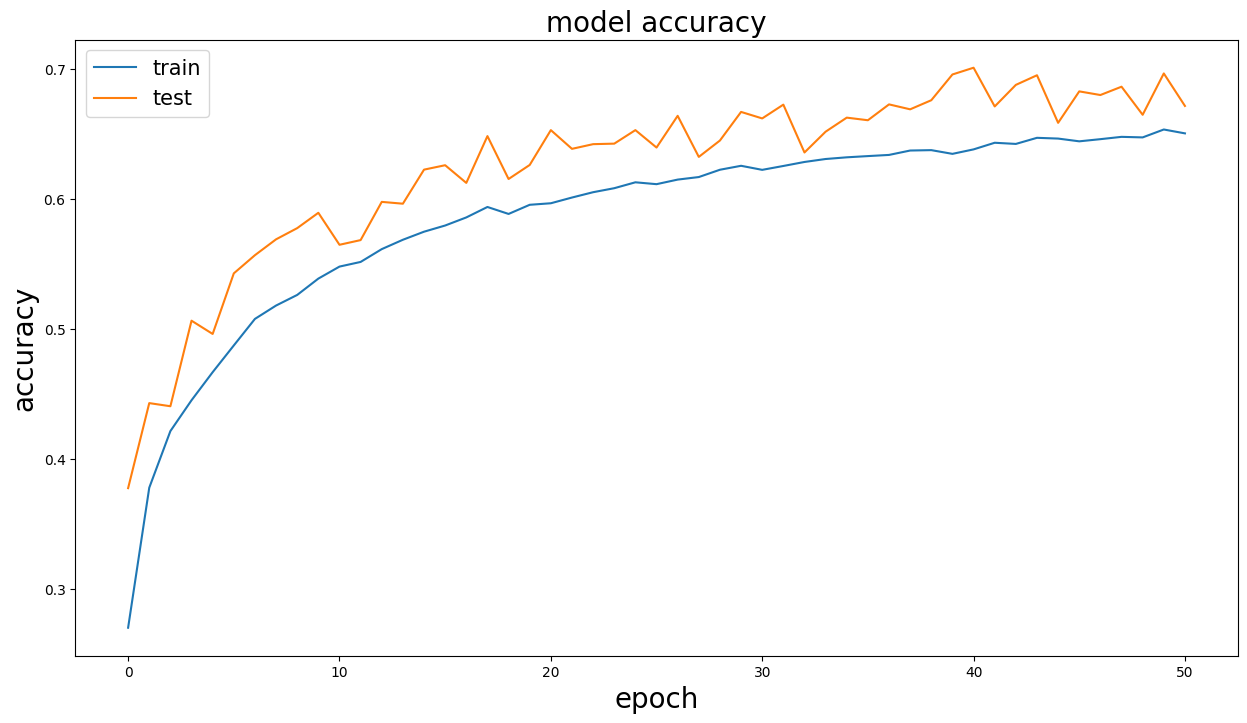

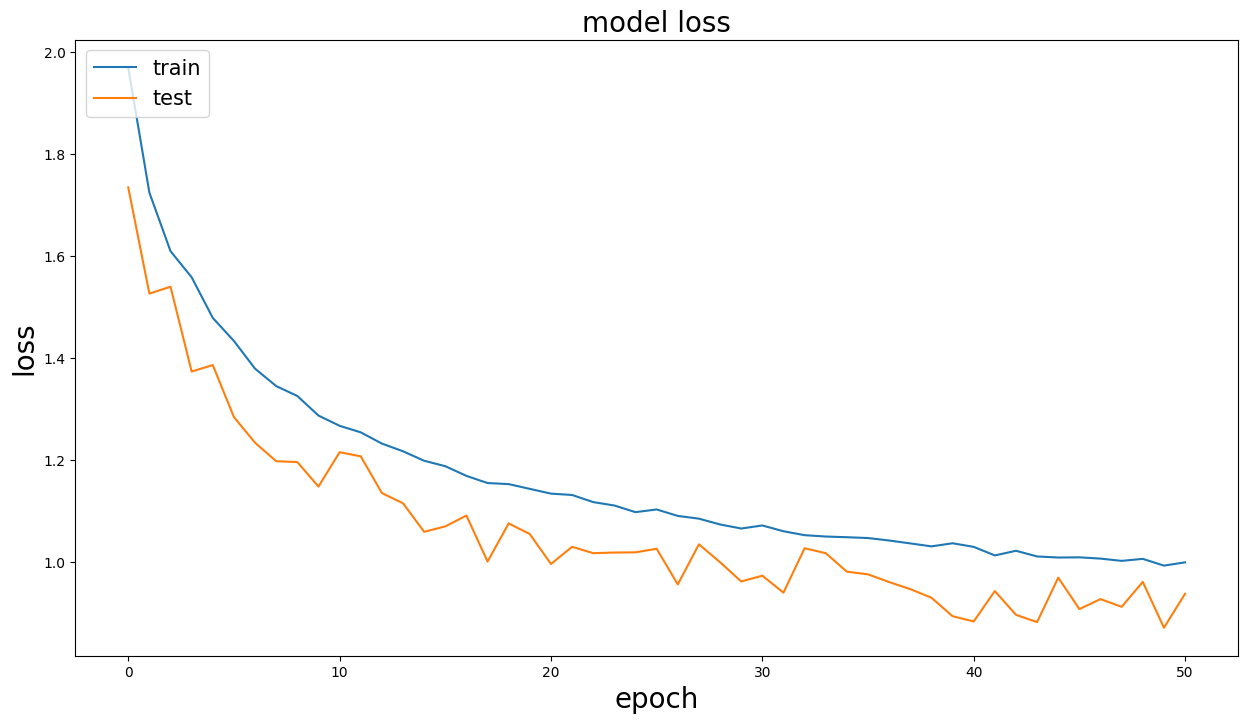

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
print(hist.history.keys())
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy', size=20)
plt.ylabel('accuracy', size=20)
plt.xlabel('epoch', size=20)
plt.legend(['train', 'test'], loc='upper left', prop={'size':15})
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss', size=20)
plt.ylabel('loss', size=20)
plt.xlabel('epoch', size=20)
plt.legend(['train', 'test'], loc='upper left', prop={'size':15})
plt.show()


157/157 [==============================] - 1s 5ms/step


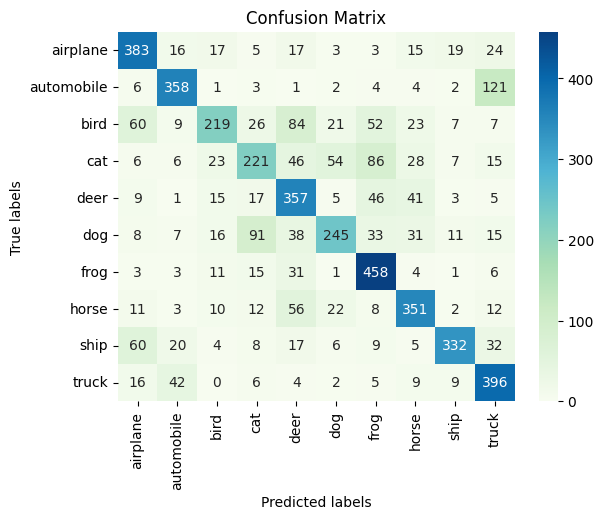

In [16]:
prediction = numpy.argmax(model_first.predict(x_test), axis=1)
test = numpy.argmax(y_test, axis=1)
plot_confusion_matrix(model_first, prediction, test, labels)

1/1 [==============================] - 0s 200ms/step


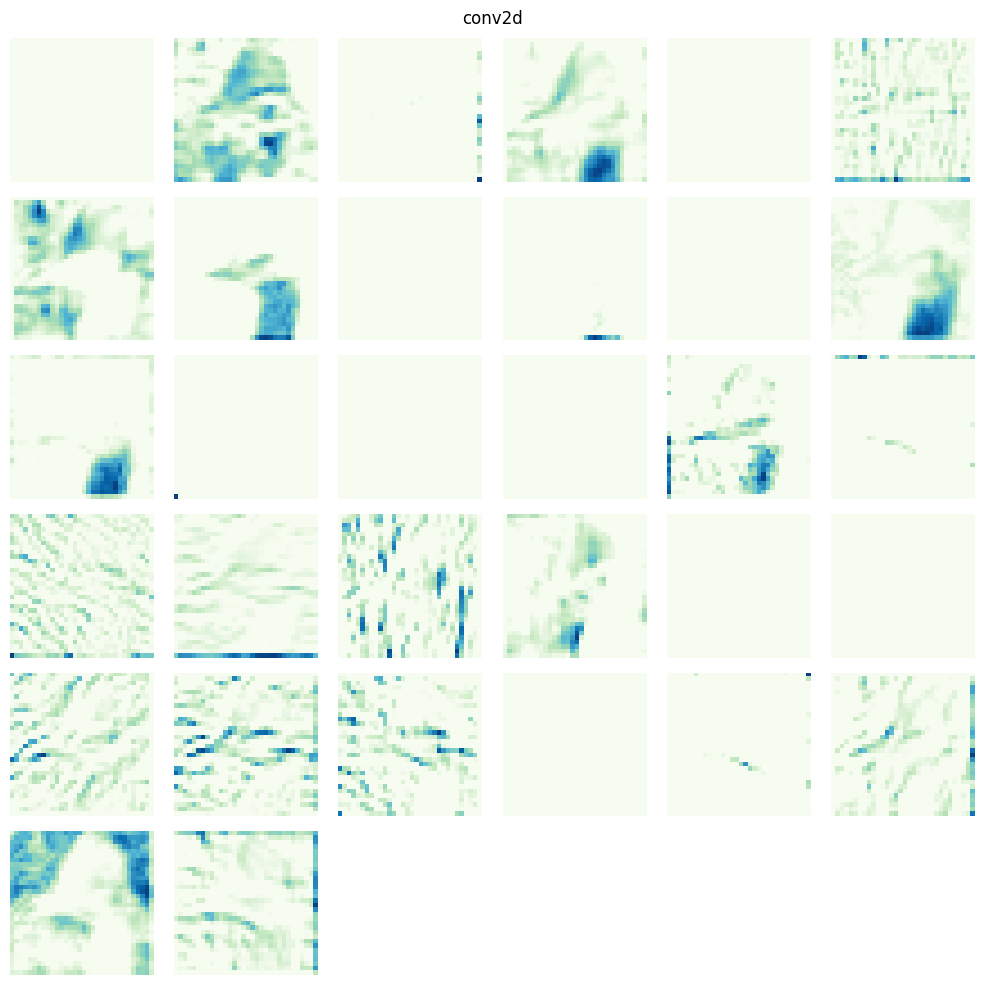

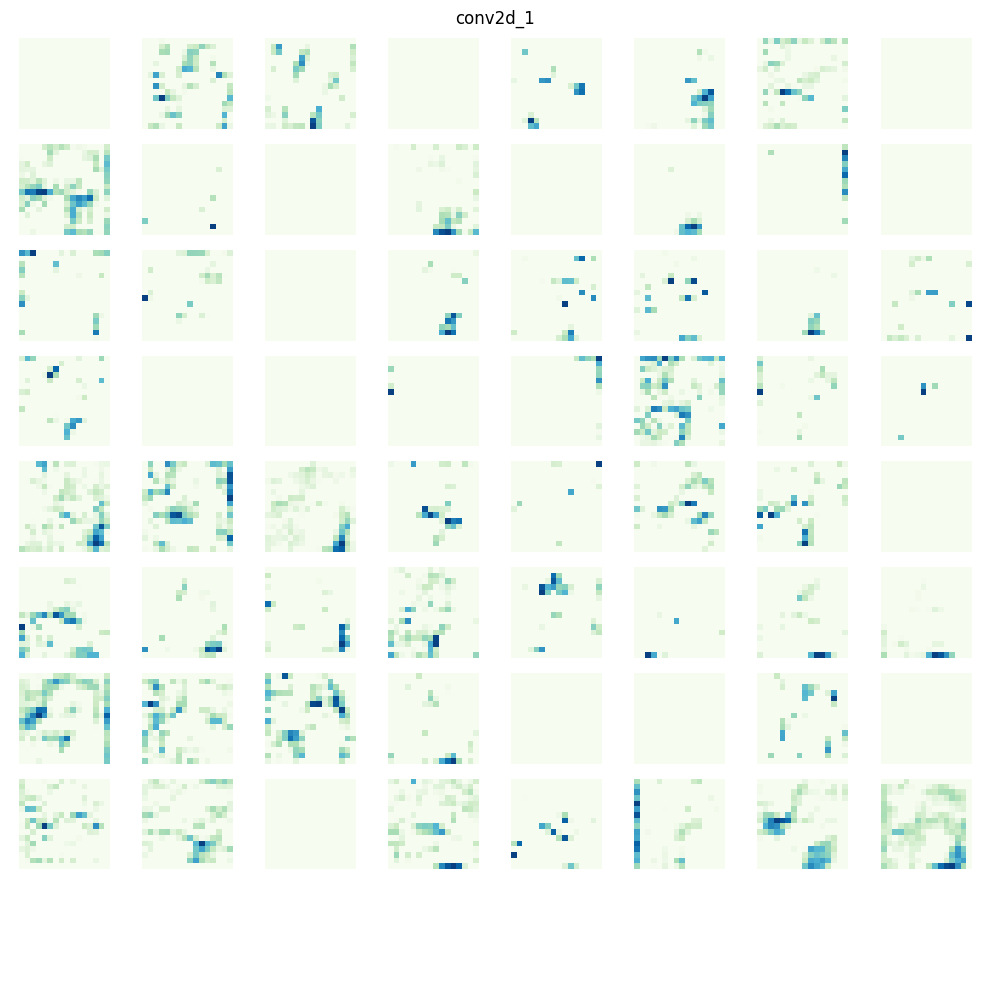

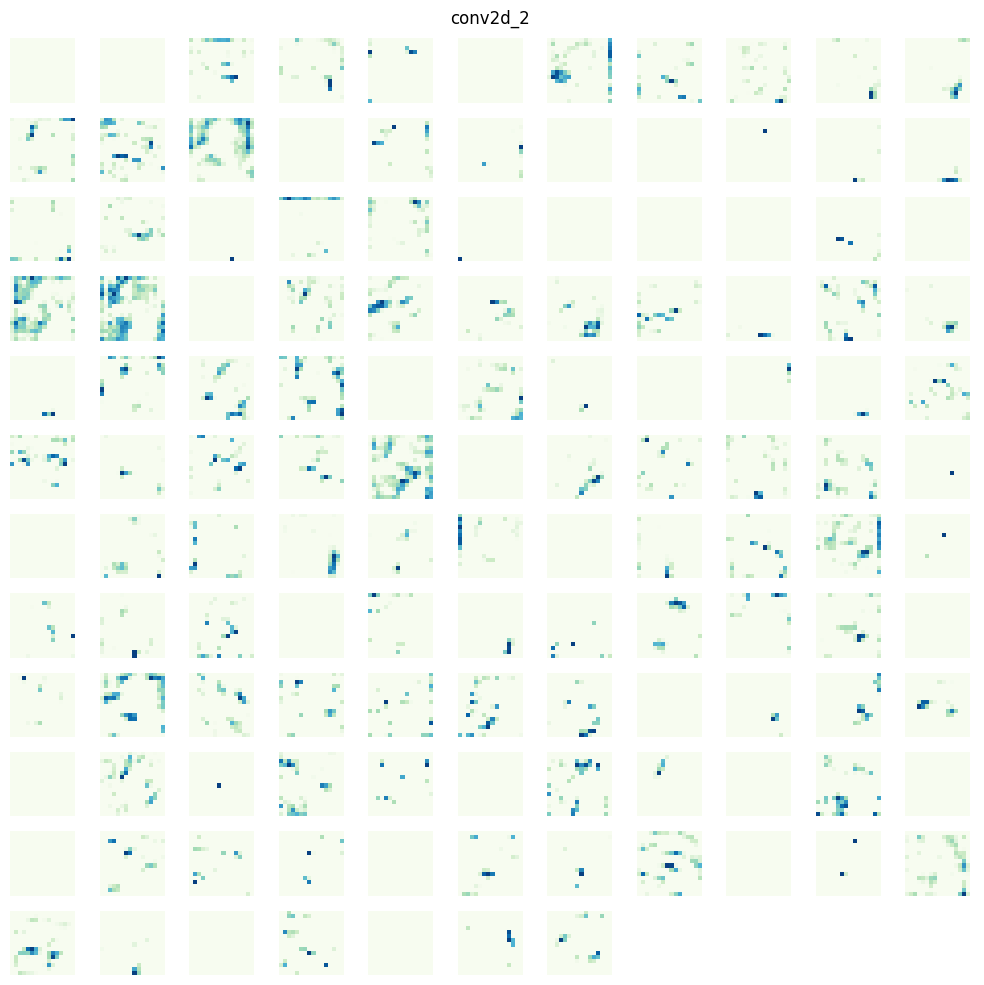

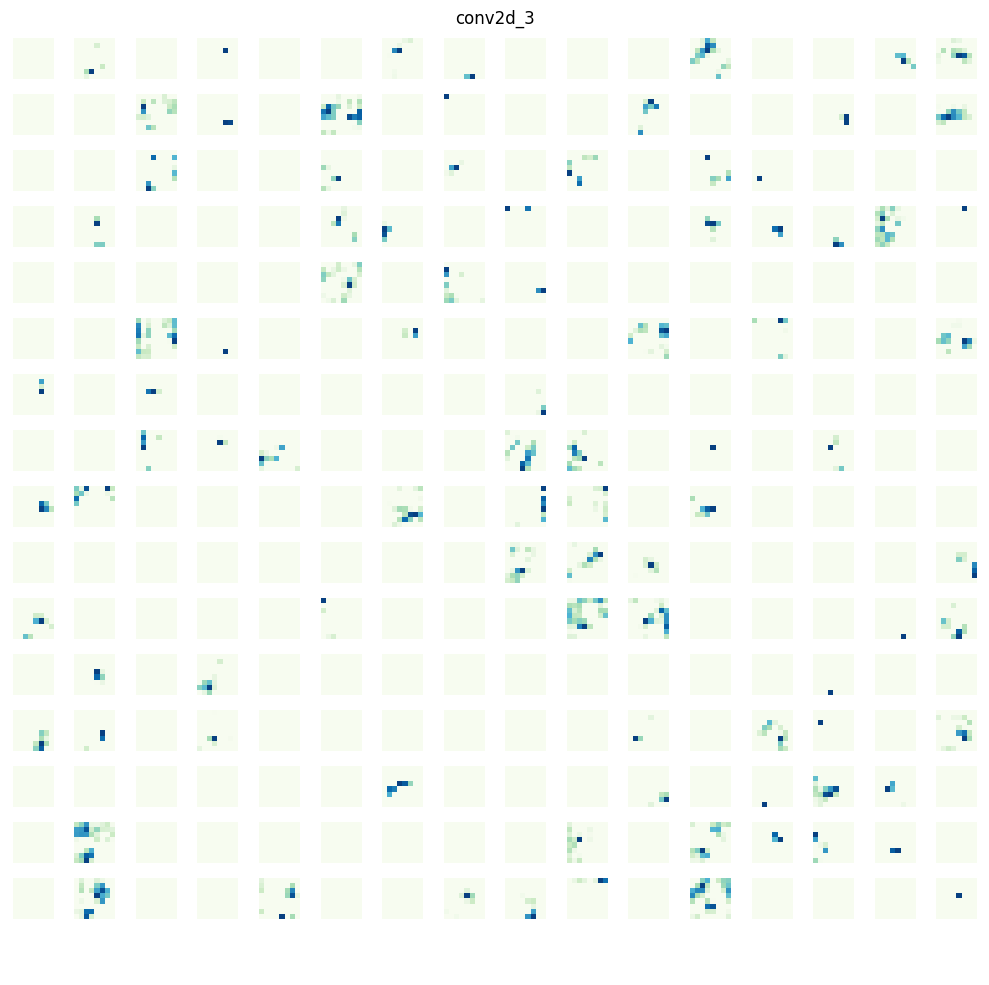

In [17]:
plot_feature_maps(model_first, figsize=(10, 10))

In [18]:
# for this second try, i changed the output layer's activation function from sigmoid to softmax and decreased the learning rate by a tenth to avoid min locals (score stays in a short value for too long and doest get better)

inputShape = (32, 32, 3)
kernel = (3, 3)
model_first_better = Sequential()

model_first_better.add(data_augmentation)

model_first_better.add(Conv2D(32, kernel, activation='relu', padding='same'))
model_first_better.add(MaxPool2D(pool_size=(2, 2)))

model_first_better.add(Conv2D(64, kernel, activation='relu', padding='same'))
model_first_better.add(Dropout(0.2))

model_first_better.add(Conv2D(128, kernel, activation='relu', padding='same'))
model_first_better.add(MaxPool2D(pool_size=(2, 2)))

model_first_better.add(Conv2D(256, kernel, activation='relu', padding='same'))
model_first_better.add(Dropout(0.3))

model_first_better.add(Flatten())
model_first_better.add(Dropout(0.2))
model_first_better.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model_first_better.add(Dropout(0.2))
model_first_better.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model_first_better.add(Dropout(0.2))
model_first_better.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
model_first_better.add(Dense(len(y_test[0]), activation='softmax'))

# Compile model
epochs = 500
model_first_better.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [58]:
model_first_better.build((None, 32, 32, 3))
model_first_better.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                      

In [19]:
# Fit the model
hist2 = model_first_better.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epochs, batch_size=128, callbacks=earlyStopping)
# Final evaluataon of the model
scores2 = model_first_better.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores2[1]*100))

Epoch 1/500
391/391 [==============================] - 13s 29ms/step - loss: 2.0218 - accuracy: 0.2470 - val_loss: 1.8054 - val_accuracy: 0.3652
Epoch 2/500
391/391 [==============================] - 9s 23ms/step - loss: 1.8001 - accuracy: 0.3489 - val_loss: 1.6722 - val_accuracy: 0.4006
Epoch 3/500
391/391 [==============================] - 9s 23ms/step - loss: 1.7077 - accuracy: 0.3851 - val_loss: 1.5659 - val_accuracy: 0.4374
Epoch 4/500
391/391 [==============================] - 9s 22ms/step - loss: 1.6314 - accuracy: 0.4129 - val_loss: 1.4921 - val_accuracy: 0.4596
Epoch 5/500
391/391 [==============================] - 9s 23ms/step - loss: 1.5876 - accuracy: 0.4283 - val_loss: 1.5188 - val_accuracy: 0.4528
Epoch 6/500
391/391 [==============================] - 10s 25ms/step - loss: 1.5372 - accuracy: 0.4466 - val_loss: 1.5557 - val_accuracy: 0.4444
Epoch 7/500
391/391 [==============================] - 8s 20ms/step - loss: 1.5134 - accuracy: 0.4566 - val_loss: 1.4125 - val_accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


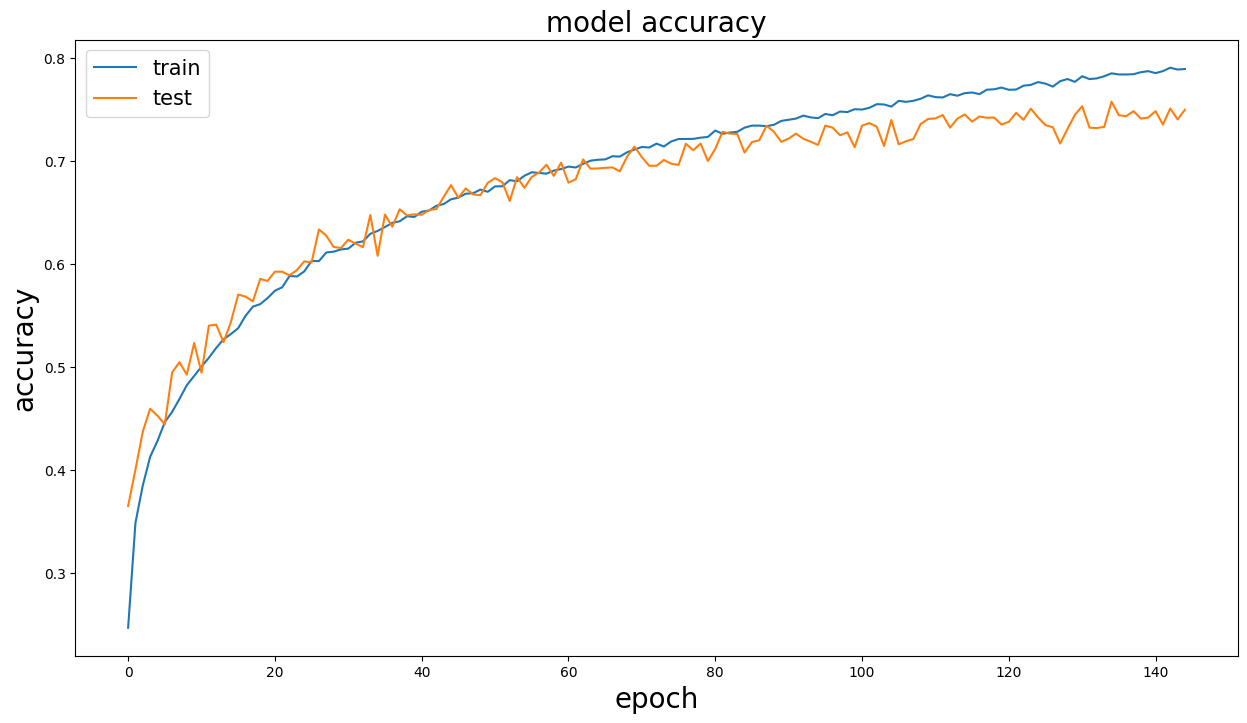

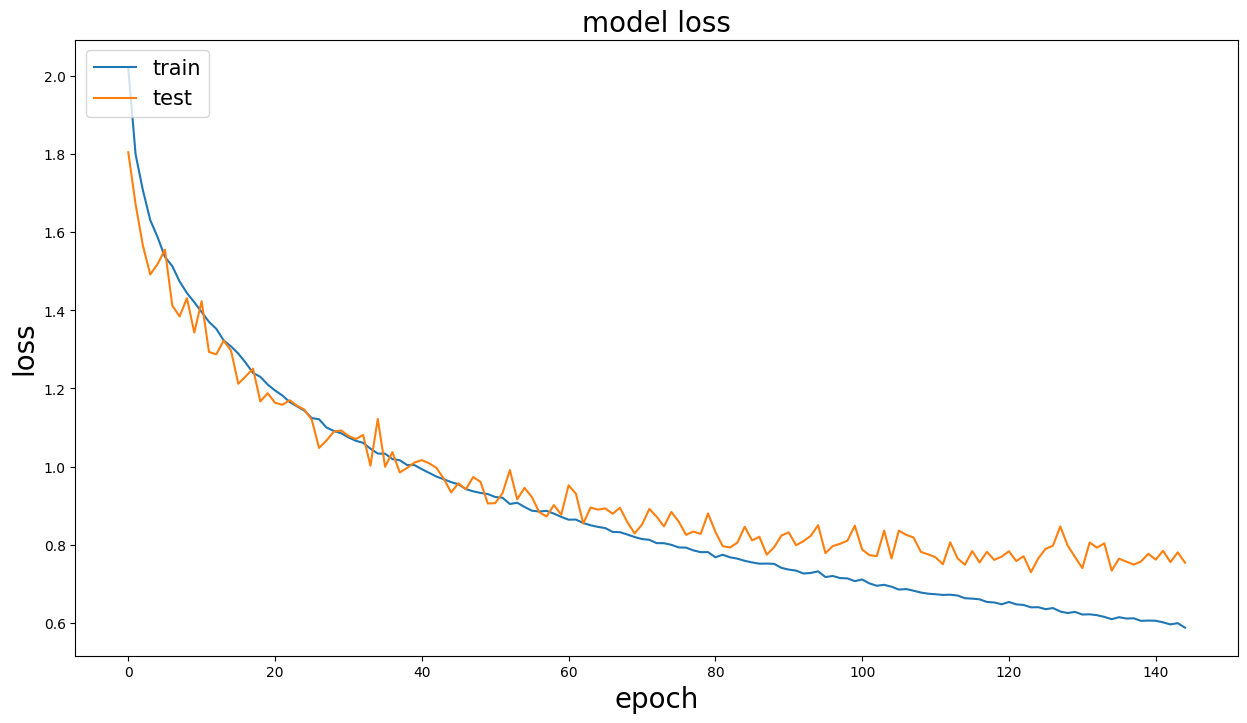

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
print(hist2.history.keys())
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy', size=20)
plt.ylabel('accuracy', size=20)
plt.xlabel('epoch', size=20)
plt.legend(['train', 'test'], loc='upper left', prop={'size':15})
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss', size=20)
plt.ylabel('loss', size=20)
plt.xlabel('epoch', size=20)
plt.legend(['train', 'test'], loc='upper left', prop={'size':15})
plt.show()

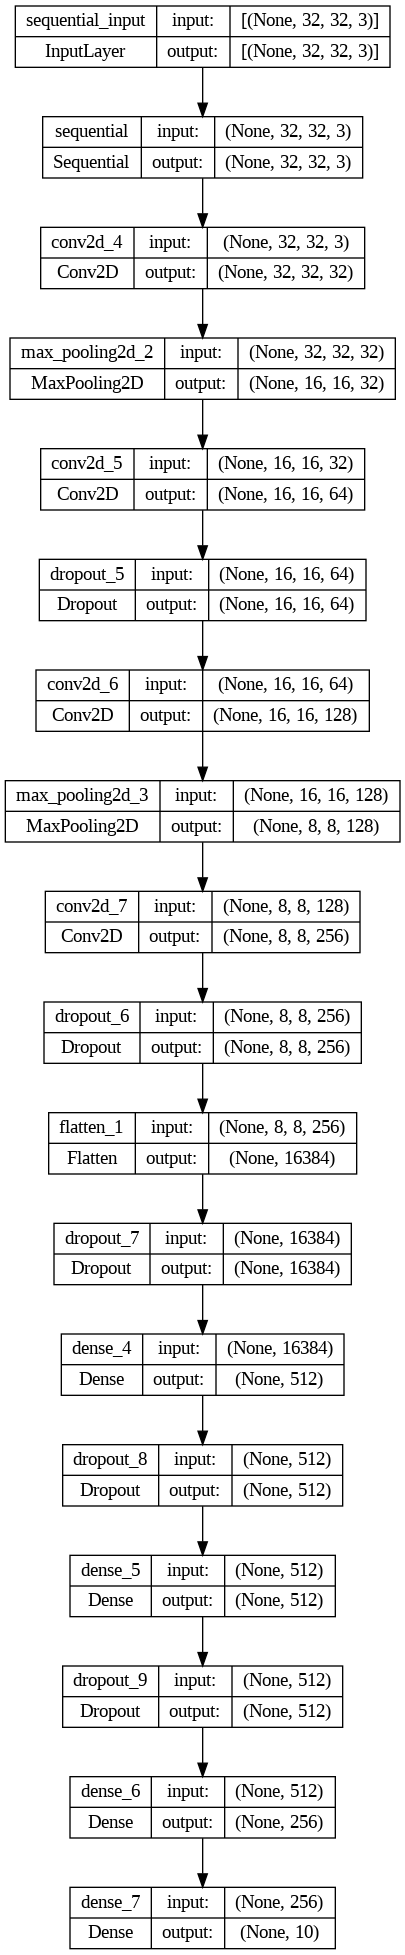

In [21]:
plot_model(model_first_better, show_shapes=True)

157/157 [==============================] - 1s 2ms/step


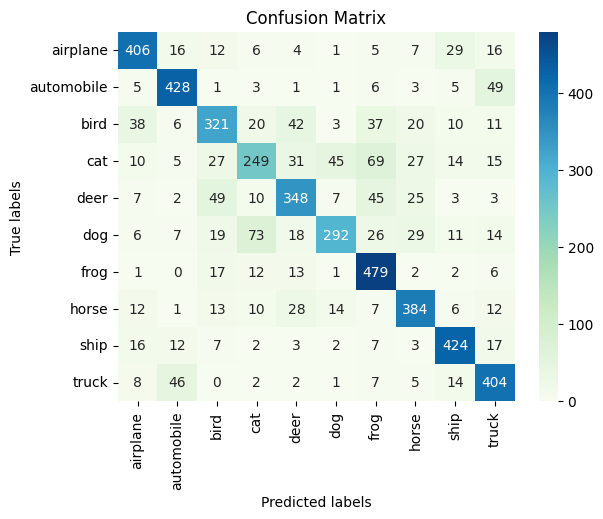

In [22]:
prediction = numpy.argmax(model_first_better.predict(x_test), axis=1)
test = numpy.argmax(y_test, axis=1)
plot_confusion_matrix(model_first_better, prediction, test, labels)

1/1 [==============================] - 0s 68ms/step


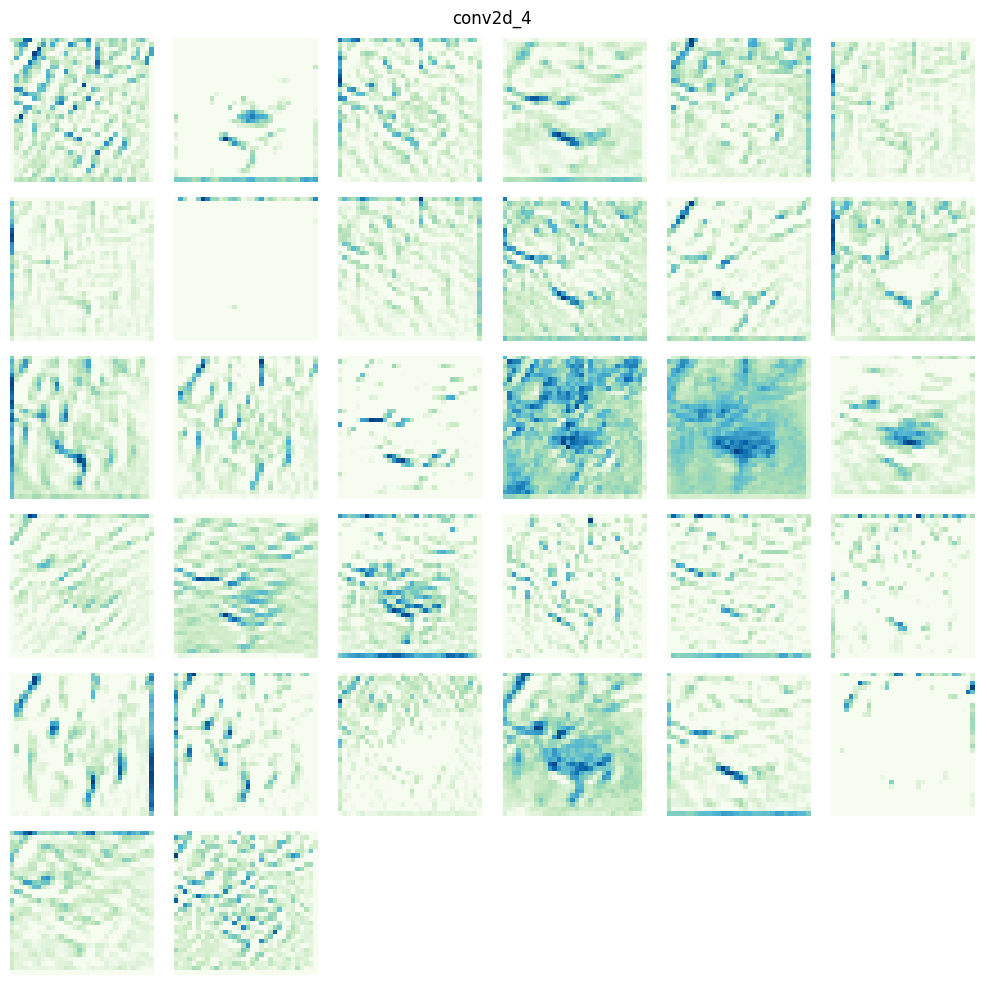

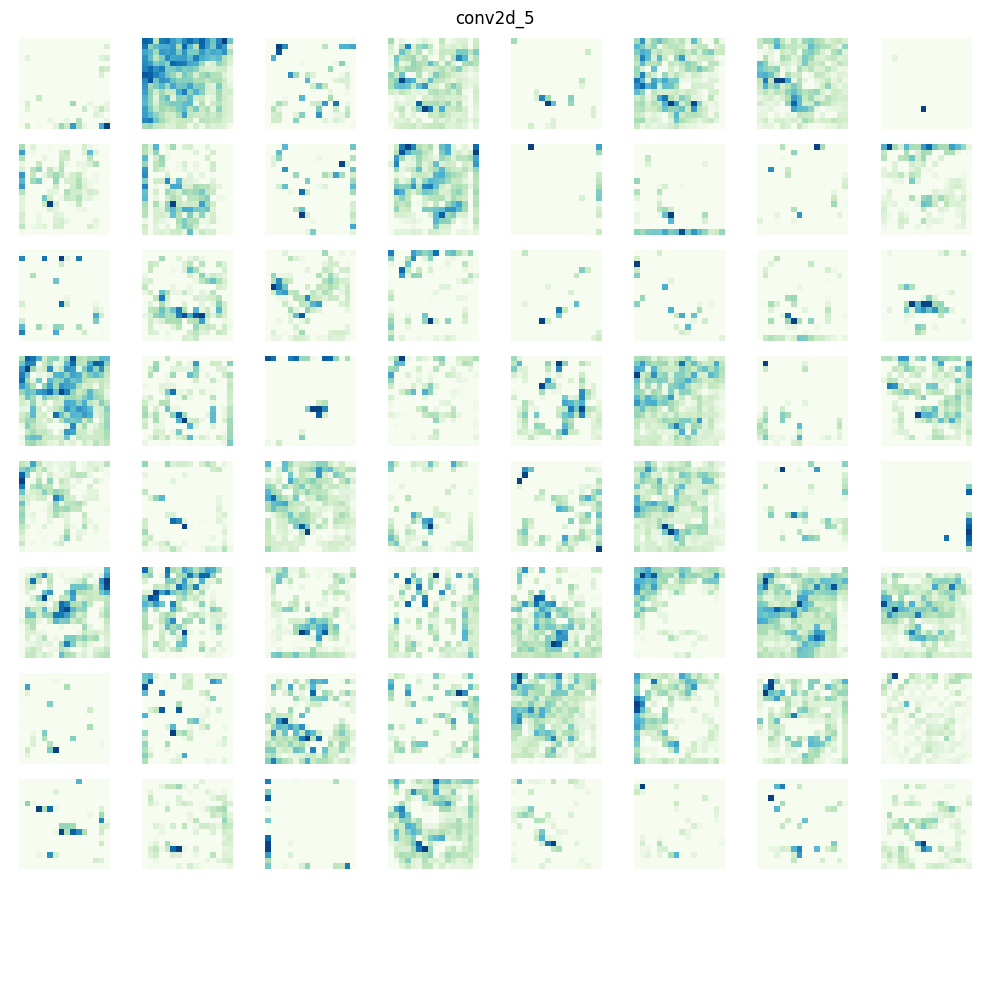

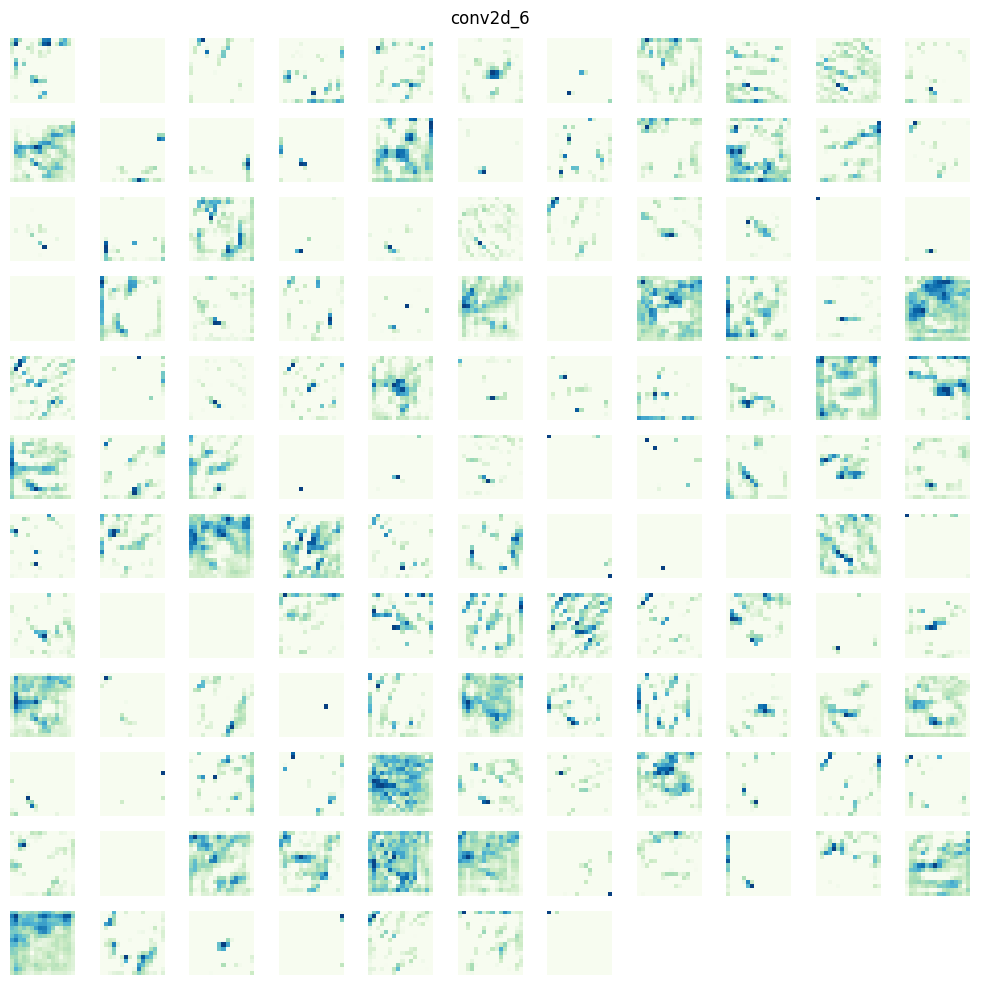

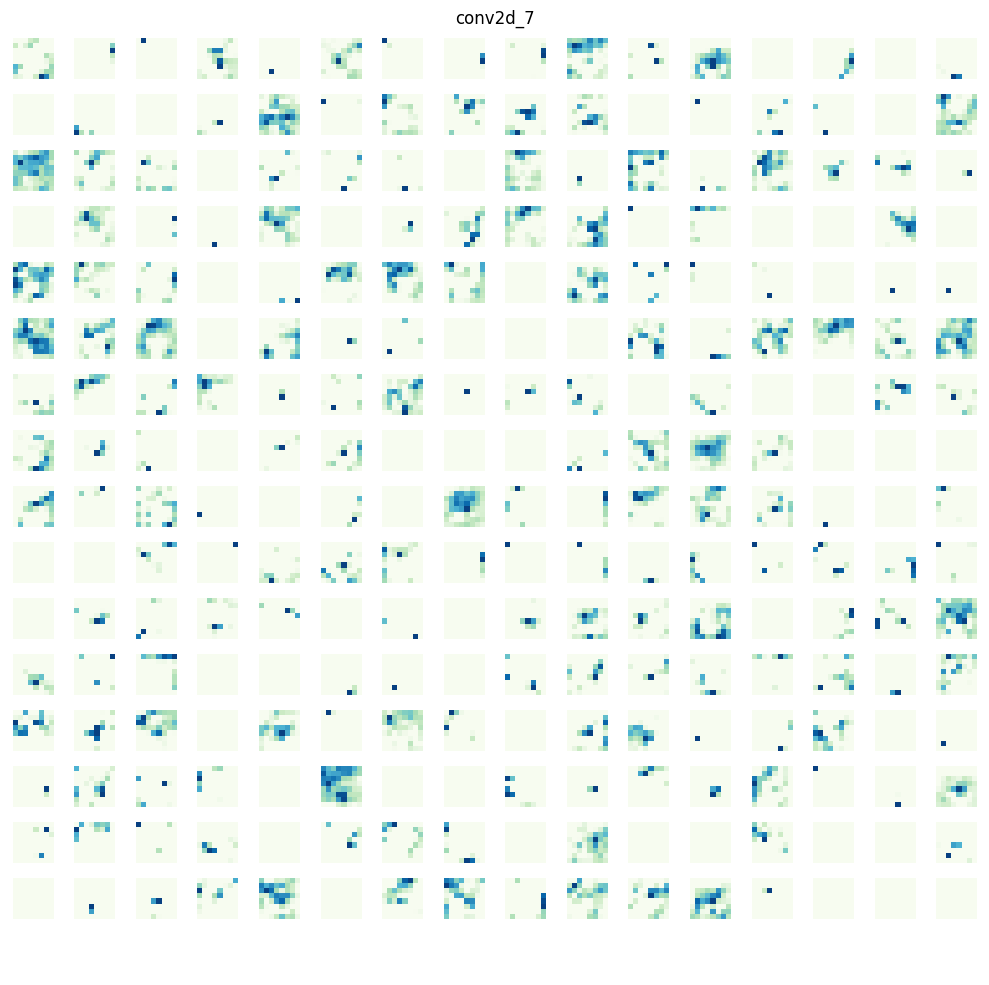

In [23]:
plot_feature_maps(model_first_better, figsize=(10, 10))

In [24]:
inputShape = (32, 32, 3)
kernel = (8, 8)
model_2 = Sequential()

model_2.add(data_augmentation)

model_2.add(Conv2D(150, kernel, input_shape=inputShape, activation='relu', padding='same'))
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(300, kernel, activation='relu', padding='same'))

model_2.add(Conv2D(300, kernel, activation='relu', padding='same'))
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

model_2.add(Conv2D(300, kernel, activation='relu', padding='same'))

model_2.add(Flatten())

model_2.add(Dense(600, activation='relu', kernel_constraint=maxnorm(3)))
model_2.add(Dense(300, activation='relu', kernel_constraint=maxnorm(3)))
model_2.add(Dense(150, activation='relu', kernel_constraint=maxnorm(3)))

model_2.add(Dense(len(y_test[0]), activation='softmax'))

# Compile model
epochs = 400
model_2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [25]:
# for the third try, i changed the size of some layers and reduced the batch_size (increasing the equivalent of learning rate) to deal with local minimums
# i also added more elements to data augmentation to avoid overfitting

# Fit the model
hist3 = model_2.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epochs, batch_size=64, callbacks=earlyStopping)
# Final evaluataon of the model
scores3 = model_2.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores3[1]*100))

Epoch 1/400
782/782 [==============================] - 117s 143ms/step - loss: 1.9790 - accuracy: 0.2670 - val_loss: 1.7537 - val_accuracy: 0.3662
Epoch 2/400
782/782 [==============================] - 110s 140ms/step - loss: 1.7349 - accuracy: 0.3705 - val_loss: 1.6075 - val_accuracy: 0.4286
Epoch 3/400
782/782 [==============================] - 110s 141ms/step - loss: 1.6050 - accuracy: 0.4238 - val_loss: 1.5421 - val_accuracy: 0.4570
Epoch 4/400
782/782 [==============================] - 110s 141ms/step - loss: 1.4929 - accuracy: 0.4632 - val_loss: 1.3453 - val_accuracy: 0.5156
Epoch 5/400
782/782 [==============================] - 110s 141ms/step - loss: 1.4116 - accuracy: 0.4928 - val_loss: 1.2933 - val_accuracy: 0.5362
Epoch 6/400
782/782 [==============================] - 110s 141ms/step - loss: 1.3402 - accuracy: 0.5201 - val_loss: 1.2411 - val_accuracy: 0.5642
Epoch 7/400
782/782 [==============================] - 110s 140ms/step - loss: 1.2962 - accuracy: 0.5358 - val_loss: 1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


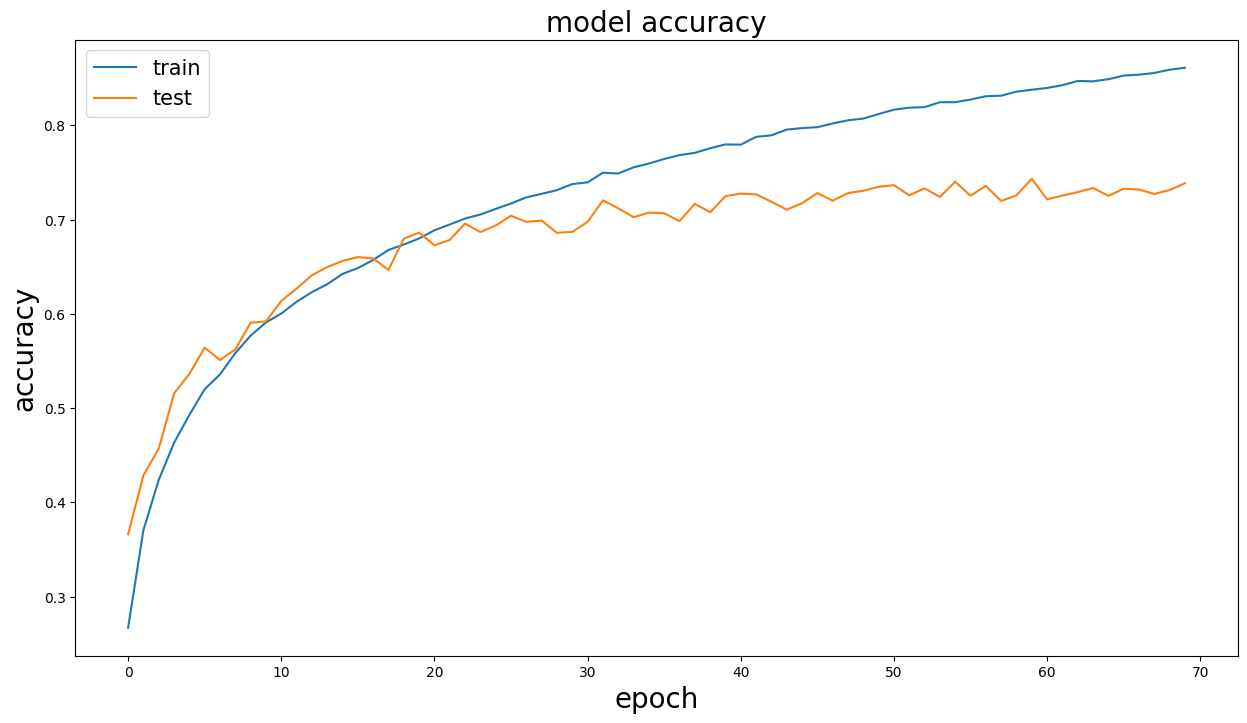

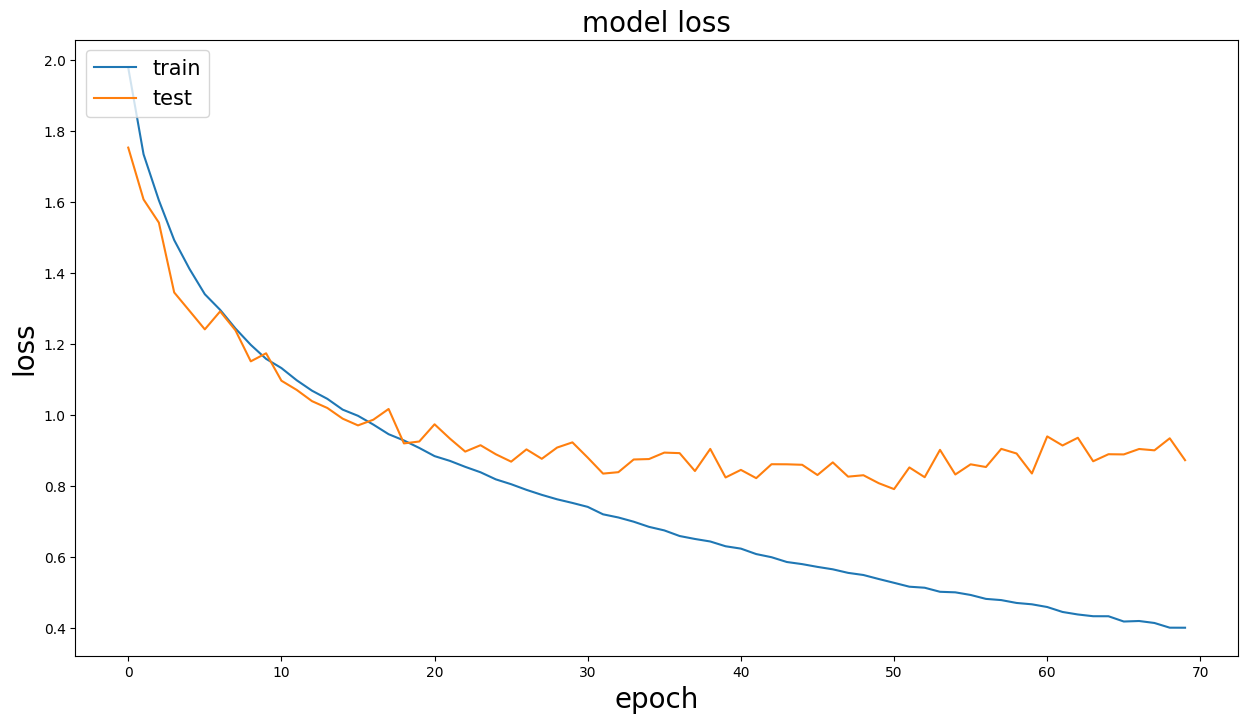

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
print(hist3.history.keys())
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('model accuracy', size=20)
plt.ylabel('accuracy', size=20)
plt.xlabel('epoch', size=20)
plt.legend(['train', 'test'], loc='upper left', prop={'size':15})
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('model loss', size=20)
plt.ylabel('loss', size=20)
plt.xlabel('epoch', size=20)
plt.legend(['train', 'test'], loc='upper left', prop={'size':15})
plt.show()

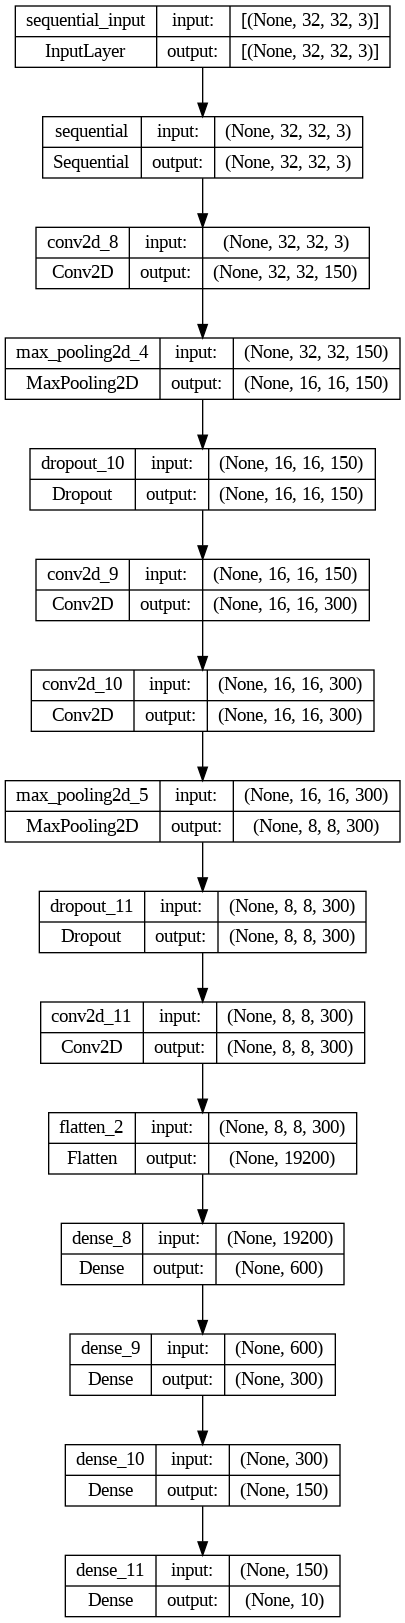

In [27]:
plot_model(model_2, show_shapes=True)

157/157 [==============================] - 2s 15ms/step


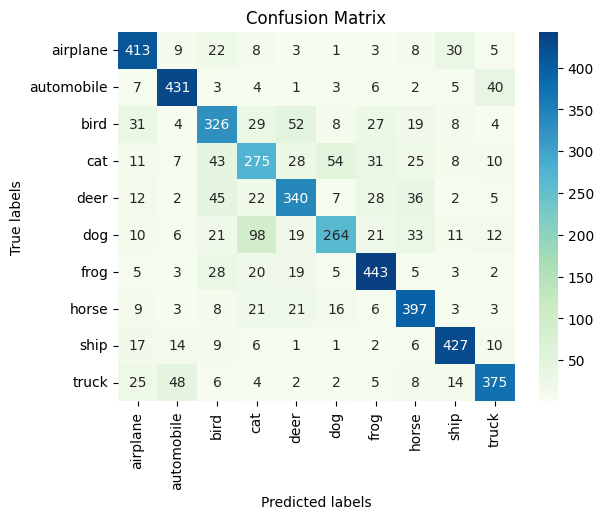

In [29]:
prediction = numpy.argmax(model_2.predict(x_test), axis=1)
test = numpy.argmax(y_test, axis=1)
plot_confusion_matrix(model_2, prediction, test, labels)

1/1 [==============================] - 0s 379ms/step


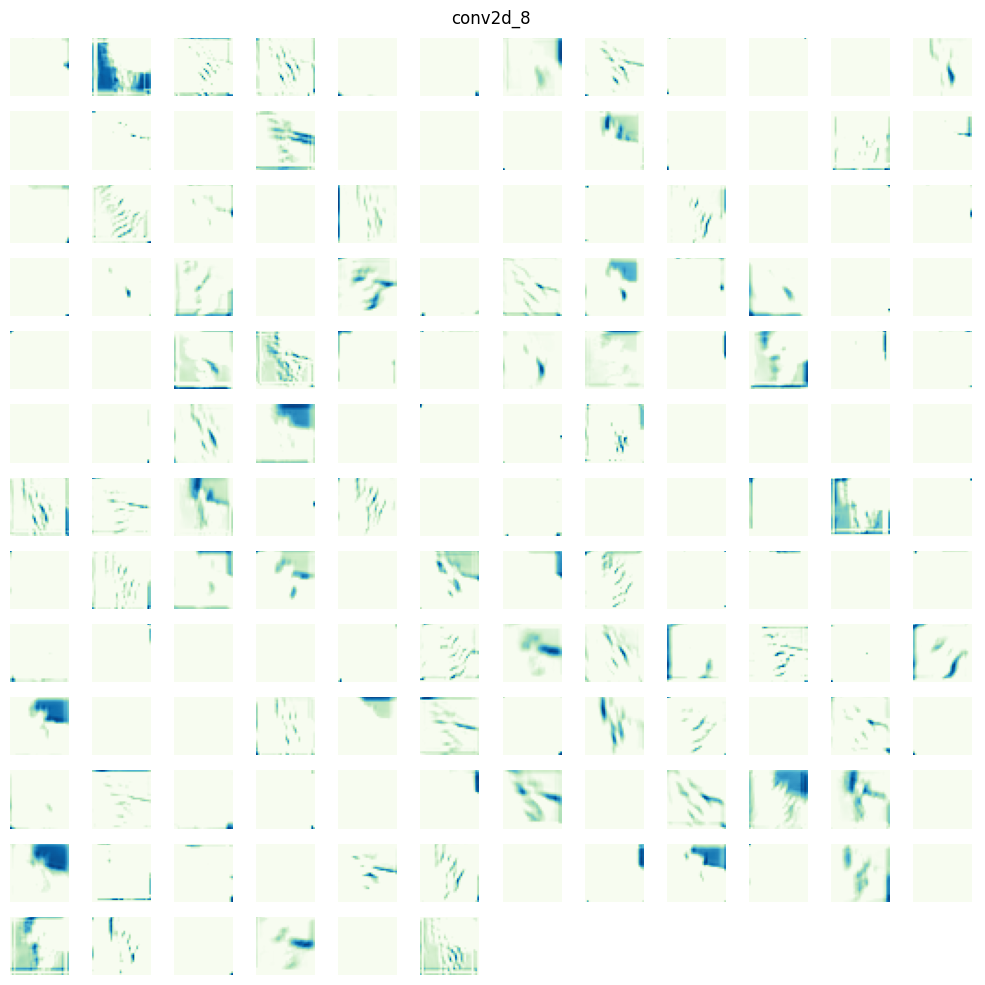

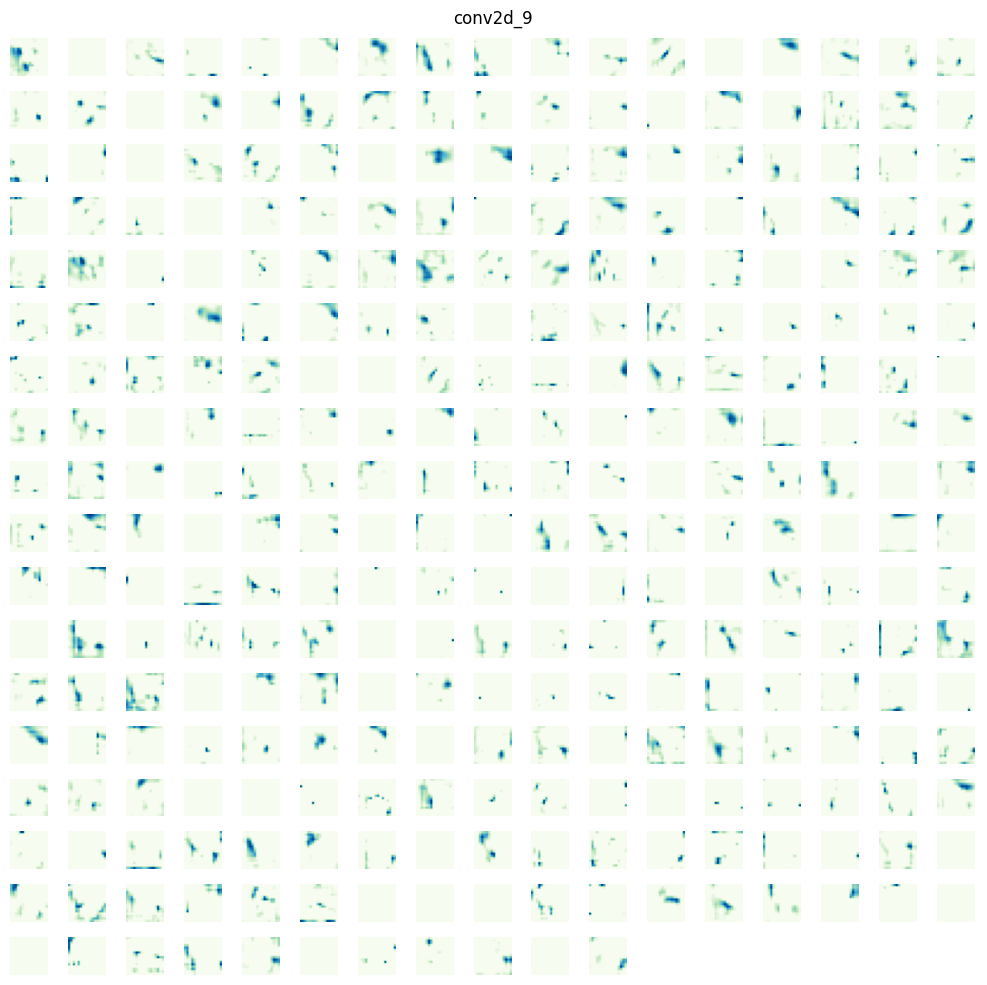

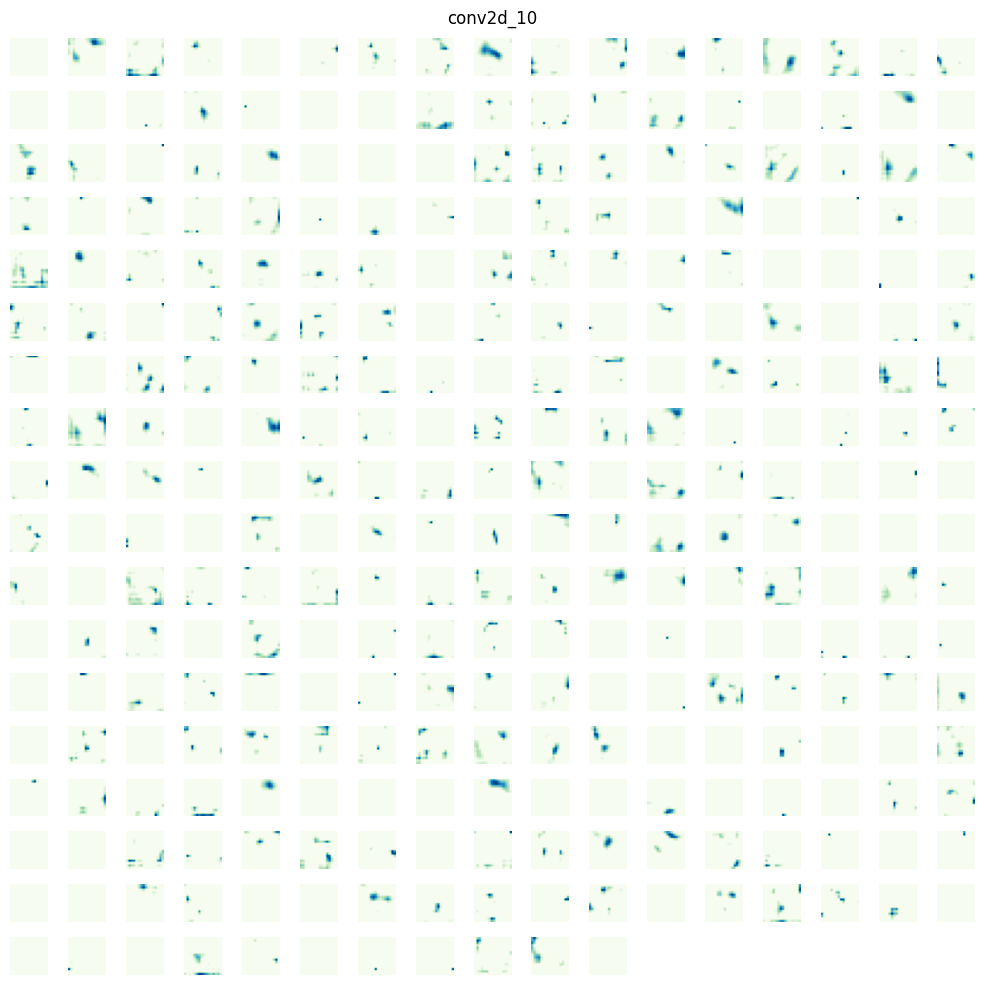

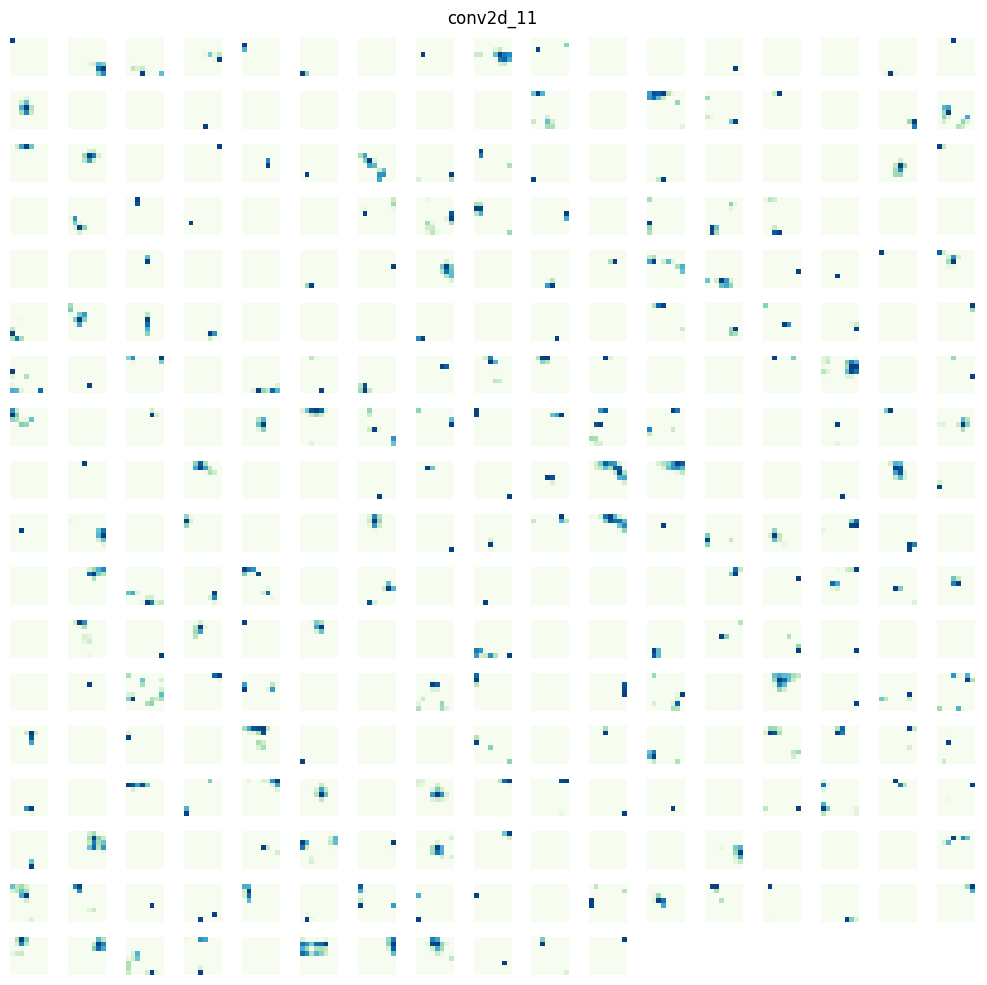

In [30]:
plot_feature_maps(model_2, figsize=(10, 10))

In [ ]:
inputShape = (32, 32, 3)
kernel = (4, 4)
model_3 = Sequential()

model_3.add(data_augmentation)

model_3.add(Conv2D(filters=32, kernel_size=kernel, activation='relu', padding='same', input_shape=inputShape))
model_3.add(Conv2D(filters=64, kernel_size=kernel, activation='relu', padding='same'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.4))

model_3.add(Conv2D(filters=128, kernel_size=kernel, activation='relu', padding='same'))
model_3.add(Conv2D(filters=256, kernel_size=kernel, activation='relu', padding='same'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.4))

model_3.add(Conv2D(filters=256, kernel_size=kernel, activation='relu', padding='same'))
model_3.add(Conv2D(filters=512, kernel_size=kernel, activation='relu', padding='same'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.4))

model_3.add(Flatten())

model_3.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model_3.add(Dropout(0.4))
model_3.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))

model_3.add(Dense(len(y_test[0]), activation='sigmoid'))

# Compile model
epochs = 200
model_3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Fit the model
hist5 = model_3.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epochs, batch_size=128, callbacks=earlyStopping)
# Final evaluataon of the model
scores5 = model_3.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores5[1]*100))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
print(hist5.history.keys())
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(hist5.history['accuracy'])
plt.plot(hist5.history['val_accuracy'])
plt.title('model accuracy', size=20)
plt.ylabel('accuracy', size=20)
plt.xlabel('epoch', size=20)
plt.legend(['train', 'test'], loc='upper left', prop={'size':15})
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title('model loss', size=20)
plt.ylabel('loss', size=20)
plt.xlabel('epoch', size=20)
plt.legend(['train', 'test'], loc='upper left', prop={'size':15})
plt.show()

In [ ]:
plot_model(model_3, show_shapes=True)

In [ ]:
prediction = numpy.argmax(model_3.predict(x_test), axis=1)
test = numpy.argmax(y_test, axis=1)
plot_confusion_matrix(model_3, prediction, test, labels)

In [ ]:
plot_feature_maps(model_3, figsize=(10, 10))

In [55]:
classify(model_first, model_first.predict(x_test), y_test, threshold=0.4)

157/157 [==============================] - 0s 3ms/step
Obtained accuracy of 0.664 with a threshold of 0.4


In [56]:
classify(model_first_better, model_first_better.predict(x_test), y_test, threshold=0.4)

157/157 [==============================] - 1s 3ms/step
Obtained accuracy of 0.7284 with a threshold of 0.4


In [57]:
classify(model_2, model_2.predict(x_test), y_test, threshold=0.4)

157/157 [==============================] - 3s 17ms/step
Obtained accuracy of 0.7276 with a threshold of 0.4


In [ ]:
classify(model_3, model_3.predict(x_test), y_test, threshold=0.4)